# Social Graphs: Explainer Notebook

In [1]:
import pandas as pd
import json
import urllib
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from fa2 import ForceAtlas2
import nltk


## Motivation

### What is your dataset?
In this notebook, we will explore a dataset composed from the *Avatar: The Last Airbender* (ATLA) [fandom wiki](https://avatar.fandom.com/wiki/Avatar_Wiki).
Specifically, the dataset consists of the character pages for all ATLA characters. This includes characters from
the sequel series *The Legend of Korra*. The fandom wiki lists a total of 625 pages related to characters.
The wiki also contains episode transcripts for both series.

### Why did you choose this particular dataset?
The ATLA dataset is well suited for analysis, both due to the appropriate number of character pages and their individual sizes.
The ATLA universe is also neatly categorized. Each character resides from one of four nations and is capable of *bending* (i.e. manipulating)
one of the four basic elements (water, air, fire and earth).
It was also important that episode transcripts were readily available, since we knew that we wanted
to employ NLP.
Finally, ATLA is a critically acclaimed animation series with a large, passionate fanbase. The authors of this notebook are also fans of the series.
We wish to appease the fans by providing additional ATLA content for consumption.

### What was your goal for the end user's experience?

Our goal is to


## Basic stats

In this section, we will firstly create the dataset through various API calls to the fandom wiki. Afterwards, we can create the character network.
Finally, descriptive statistics and visualizations concerning the dataset and network will take place.

### Extracting characters from Avatar: The Last Airbender fandom wiki

Here the all character names and nationalities from the wiki are extracted. The wiki contains several category pages that we can use for this purpose. Since we are interested in finding the nationality of each character, we will use the following category pages:
- Water Tribe characters
- Earth Kingdom characters
- Fire Nation characters
- United Republic characters

The first four category pages are the archetypical countries in ATLA. The last country, the *United Republic*, is only introduced later on in *The Legend of Korra* and can be seen as an amalgation of the previous four. Using the above pages, the nationality of each character can be found without additional scraping. However, there are also characters that are not associated with a country. In order to find these characters, we will also use the top-level character category page containing **all** character in the universe.

We do a small amount of data-cleaning regarding the characters included. A few characters are exclusive to non-canon video games and pilot episodes. We therefore exclude these.

In [3]:
data = pd.DataFrame({'name': [], 'nationality': []})

In [4]:
url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Characters&cmlimit=500&prop=revisions&rvprop=content&rvslots=*'
base_url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:'
page_titles = ['Water_Tribe_characters', 'Earth_Kingdom_characters', 'Fire_Nation_characters', 'Air_Nation_characters', 'United_Republic_characters', 'Characters']
character_nationalities = ['Water Tribe', 'Earth Kingdom', 'Fire Nation', 'Air Nation', 'United Republic', None]
end_url = '&cmlimit=500&prop=revisions&rvprop=content&rvslots=*&format=json'

for page_title, character_nationality in zip(page_titles, character_nationalities):
    url = base_url + page_title + end_url
    response = urllib.request.urlopen(url)
    page = json.load(response)
    category_members = page['query']['categorymembers']
    
    # Extract page title and character nationality.
    character_names = [item['title'] for item in category_members] 
    
    # Some pages may be longer than 500 members.
    if 'continue' in page.keys():
        cmcont = page['continue']['cmcontinue']
        url = base_url + page_title + end_url + '&cmcontinue=' + cmcont
        response = urllib.request.urlopen(url)
        page = json.load(response)
        category_members = page['query']['categorymembers']
        character_names += [item['title'] for item in category_members] 
        
    
    # Some Category:* items will be included. These are not important, so we can discard them.
    # We also don't want any characters from games or pilot episodes.
    filtered = filter(lambda title: 'Category:' not in title and 'pilot' not in title and 'games' not in title, character_names)
    character_names = list(filtered)

    # Might as well get nationality here.
    name_and_type = {'name': character_names, 'nationality': [character_nationality for _ in character_names]}

    # Merge with existing data frame.
    df = pd.DataFrame.from_dict(name_and_type)
    data = data.append(df)

    
# A few characters can get included multiple times.
data = data.drop_duplicates(subset='name')

# Some entries might have duplicate indices
data = data.reset_index(drop=True)

data.head(10)


,name,nationality
0,Amak,Water Tribe
1,Amon,Water Tribe
2,Arnook,Water Tribe
3,Ashuna,Water Tribe
4,Atuat,Water Tribe
5,Bato,Water Tribe
6,Desna and Eska,Water Tribe
7,Due,Water Tribe
8,Gilak,Water Tribe
9,Hahn,Water Tribe


In [5]:
data.shape

(572, 2)

As seen above, we managed to extract $572$ characters from the category pages. This also means that our network will be close to the same size.

### Downloading character pages

With all character names collected, we can begin extracting individual character pages. The character pages will be used to link character nodes in the network, as done previously in the course. The will also be used to extract additional attributes. The contributors of the wiki have almost completely eliminated the need for disambiguation pages and redirects, making the whole process very simple.

In [6]:
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=revisions&rvprop=content&rvslots=*&format=json'

for character_name in data['name'].to_numpy():
    # Create URL
    print(character_name)
    original_name = character_name
    page_title = character_name.replace(' ', '_')
    
    url = base_url + urllib.parse.quote_plus(page_title) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['revisions'][0]['slots']['main']['*']
    
    # Save to file
    with open('characters/' + original_name.replace('/', '-') + '.txt', 'w') as file:
        file.write(page_content)

Amak
Amon
Arnook
Ashuna
Atuat
Bato
Desna and Eska
Due
Gilak
Hahn
Hakoda
Hama
Hiryu
Hotah
Huu
Iknik Blackstone Varrick
Kam
Kanna
Katara
Kinto
Kirima
Korra
Kuruk
Kya
Kya (nonbender)
La
Lirin
Malina
Maliq
Naga
Nini
Niyok
Noa
Nutha
Pakku
Rafa and Misu
Roku's waterbending master
Sangok
Senna
Siku and Sura
Slim
Sokka
Southern Water Tribe boy
Southern Water Tribe girl
Tarrlok
Tho
Thod
Thod's disciples
Tonraq
Tui
Ummi
Unalaq
Visola
Wei
White Lotus leader
Fanon:The Winter Moon
Yagoda
Yakone
Yakone's wife
Yue
46th Earth King
Aiwei
Animal control officer
Aoma
Arik
Ba Sing Se airship captain
Ba Sing Se University student
Baatar
Baatar Jr.
Baraz and Ahnah
Bathroom attendant
The Big Bad Hippo
Biyu
Bosco
The Boulder
Broadsword man
Bumi (King of Omashu)
Bumi's advisor
Cabbage merchant
Calm man
Canyon guide
Captured agent
Chin
Chio
Chong
Chow
Corncob guy
Dai Li sergeant
The Dark One
The Duke
Earth Empire fugitives
Earthbender captain
Earthbending academy teenagers
Farmer and wife
Feng (waitress)
Fire N

In [7]:
data.to_csv('avatar_data.csv')

In [21]:
data = pd.read_csv('avatar_data.csv')

We'll also need to download the pages as plain text for NLP later on. This is done by adding `&prop=extract&explaintext` to the API call.

In [8]:
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=extracts&explaintext&format=json'

for character_name in data['name'].to_numpy():
    # Create URL
    original_name = character_name
    page_title = character_name.replace(' ', '_')
    
    url = base_url + urllib.parse.quote_plus(page_title) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['extract']
    
    # Save to file
    with open('characters_plain_text/' + original_name.replace('/', '-') + '.txt', 'w') as file:
        file.write(page_content)

## Extracting links and creating the network

All data collection required for creating the network is now done. We will now traverse each character page and find hyperlinks to other character pages. This will allow us to create the social network for the ATLA universe. Along the way, character attributes will also be extracted.

It's easiest to first create all nodes in our graph and add all the according attributes. The links will be created after this process.
Each character node posseses the following attributes:
- Nationality
- Gender
- Bending style


This code is used for extracting the bending style of a character. We again use the neatly organized category pages from the wiki. Not all characters are capable of bending - those are labelled as `non-bender`s.

In [10]:
url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Characters&cmlimit=1000&prop=revisions&rvprop=content&rvslots=*'
base_url = 'https://avatar.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:'
end_url = '&cmlimit=500&prop=revisions&rvprop=content&rvslots=*&format=json'


def category_to_list(page_title):
    url = base_url + page_title + end_url
    response = urllib.request.urlopen(url)
    page = json.load(response)
    category_members = page['query']['categorymembers']
    
    # Extract page title and character nationality.
    character_names = [item['title'] for item in category_members] 
    
    # Some Category:* items will be included. These are not important, so we can discard them.
    # We also don't want any characters from games or pilot episodes.
    filtered = filter(lambda title: 'Category:' not in title and 'pilot' not in title and 'games' not in title, character_names)
    character_names = list(filtered)
    return character_names

water_benders = category_to_list('Waterbenders')
air_benders = category_to_list('Airbenders')
fire_benders = category_to_list('Firebenders')
earth_benders = category_to_list('Earthbenders')

def bending_art(name):
    if name in water_benders:
        return 'Waterbender'

    if name in earth_benders:
        return 'Earthbender'

    if name in air_benders:
        return 'Airbender'
    
    if name in fire_benders:
        return 'Firebender'
    
    return 'Non-bender'
    

The following code cell firstly creates all character nodes and inserts attributes. The `gender` attribute is the only attribute that requires RegEx for extraction. 

Gender is typically represented like so:
```
| gender = Male
```
making it easy to extract via a RegEx pattern: `\|[\s]*gender[\s]*=[\s]*(\w+)\n`. The pattern takes into account that there may be a varying amount of whitespace between keywords.

In [14]:
G = nx.DiGraph()
gender_pat = r'\|[\s]*gender[\s]*=[\s]*(\w+)\n'
for name, nationality in data[['name', 'nationality']].to_numpy():
    with open('characters/' + name.replace('/', '-') + '.txt', 'r') as file:
        gender = None
        
        page_content = file.read()

        gender_match = re.findall(gender_pat, page_content)
        if gender_match:
            gender = gender_match[0]
        
        bending_style = bending_art(name)
        G.add_node(name, nationality=nationality, gender=gender, bending_art=bending_style)

Now we'll extract the hyperlinks from the character pages and create the links in the network.

The Avatar wiki only uses `[[...]]` links, which makes link extraction significantly easier. This allows us to get by with a single RegEx pattern: 
`\[\[(.*?)(?:#.*?)?(?:\|.*?)?\]\]`. 

The pattern takes a couple of cases into account. Some hyperlinks are of the form `[[<character_name>#<section>]]` and `[[<character_name> | <alias>]]`. In all cases, we are only interested in `<character_name>`. Most hyperlinks are of the most basic form `[[<character_name>]]`.

In [16]:
# Patterns for detecting links
pat1 = r'\[\[(.*?)(?:#.*?)?(?:\|.*?)?\]\]'

for name in data['name'].to_numpy():
    print('Finding relations for', name)
    
    # Open the appropriate text file containing character wiki page previously saved
    with open('characters/' + name.replace('/', '-') + '.txt', 'r') as file:
        page_content = file.read()

        # Convert to set to eliminate duplicates
        page_names = set(re.findall(pat1, page_content))

        for page_name in page_names:
            filtered_name = page_name.replace('+', '\+').replace('(', '\(').replace(')', '\)')
            
            # No self referencing either!
            if data['name'].str.fullmatch(filtered_name).any() and filtered_name != name:
                G.add_edge(name, page_name)

Finding relations for Amak
Finding relations for Amon
Finding relations for Arnook
Finding relations for Ashuna
Finding relations for Atuat
Finding relations for Bato
Finding relations for Desna and Eska
Finding relations for Due
Finding relations for Gilak
Finding relations for Hahn
Finding relations for Hakoda
Finding relations for Hama
Finding relations for Hiryu
Finding relations for Hotah
Finding relations for Huu
Finding relations for Iknik Blackstone Varrick
Finding relations for Kam
Finding relations for Kanna
Finding relations for Katara
Finding relations for Kinto
Finding relations for Kirima
Finding relations for Korra
Finding relations for Kuruk
Finding relations for Kya
Finding relations for Kya (nonbender)
Finding relations for La
Finding relations for Lirin
Finding relations for Malina
Finding relations for Maliq
Finding relations for Naga
Finding relations for Nini
Finding relations for Niyok
Finding relations for Noa
Finding relations for Nutha
Finding relations for Pa

With all links created, let us inspect the final graph briefly.

In [17]:
print('Number of nodes:', G.number_of_nodes())
print('Number of links:', G.number_of_edges())

Number of nodes: 572
Number of links: 6274


We find the network to contain $572$ nodes and $6274$ links. The number of nodes is exactly as expected, as this was the number of character pages found. We find the number of links to be relatively large. It appears that characters in the ATLA universe are, on average, well connected.

Let us now create the GCC. Here we hope that the GCC is not significantly smaller, as that could cause issues. We don't want a network containing very few nodes.

In [18]:
component_list = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
GCC = G.subgraph(component_list[0]).copy()

And let us inspect it as before:

In [19]:
print('Number of nodes:', GCC.number_of_nodes())
print('Number of links:', GCC.number_of_edges())

Number of nodes: 571
Number of links: 6274


We find this to be a success. The GCC only contains 1 node less than the original network. This is perhaps surprising in itself. It indicates that nearly *all* characters are connected and part of a single component.

## Extracting character dialogue from episode transcripts


Since we wish to perform NLP, we will need dialogue associated with each chararcter. The fandom wiki contains transcripts for each episode of both series, which we will use for this purpose. This will require some fiddling, but is overall not particularly difficult.

Our first job is finding the name, book and episode number of each episode. The wiki contains a page for each season of a series. These pages include all episodes of their corresponding season (book) and associated data.

The first series, *Avatar: The Last Airbender*, contains in total 3 books:
- Book One: Water
- Book Two: Earth
- Book Three: Fire

The second series, *The Legend of Korra*, contains in total 4 books:
- Book One: Air
- Book Two: Spirits
- Book Three: Change
- Book Four: Balance

For example, here is an small excerpt from the page regarding the first season of ATLA:

```
| {{Episode box
| series   = 1
| number   = 101
| name     = The Boy in the Iceberg
| image    = Aang in the iceberg.png
| airdate  = February 21, 2005
| writer   = [[Michael Dante DiMartino]], [[Bryan Konietzko]]
| director = [[Dave Filoni]]
| summary  = [[Sokka]] and [[Katara]], two teenage siblings living in the South Pole, discover [[Aang]] and his pet [[flying bison]], [[Appa]], trapped in an iceberg. After Katara frees him, she discovers that he is an [[Airbending|airbender]] and the siblings take him to their home village in the [[Southern Water Tribe]]. Meanwhile, his unfreezing attracts the attention of the Fire Nation's [[Zuko]] intent on capturing him.}}
```

The above shows the `Episode box` for the first episode, *The Boy in the Iceberg*. The information we are interested in here is `series` and `name`. `number` is not useful, since we can easily deduce this later on.
We use a simple RegEx pattern to extract the above.

In [21]:
episode_info_df = pd.DataFrame({'name': [], 'book': [], 'book_number': [], 'episode_number': [], 'series': []})

In [22]:
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=revisions&rvprop=content&rvslots=*&format=json'
page_names = ['Book_One:_Water', 'Book_Two:_Earth', 'Book_Three:_Fire', 'Book_One:_Air', 'Book_Two:_Spirits', 'Book_Three:_Change', 'Book_Four:_Balance']
books = [('Water', '1', '1'), ('Earth', '1', '2'), ('Fire', '1', '3'), ('Air', '2', '1'), ('Spirits', '2', '2'), ('Change', '2', '3'), ('Balance', '2', '4')]

episode_pat = r'\| series   = ([0-9])\s\| number   = [0-9]+\s\| name     = ([\w 0-9 \':,.]+)\s'

for page_name, (book_name, _, book_number) in zip(page_names, books):
    # Episode number is found manually
    episode_number = 1

    # Create URL
    url = base_url + urllib.parse.quote_plus(page_name) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['revisions'][0]['slots']['main']['*']
    
    episode_names = []
    book_names = []
    book_numbers = []
    episode_numbers = []
    series_numbers = []
    
    # Collect episodes for a book
    matches = re.findall(episode_pat, page_content)
    for match in matches:
        series = match[0]
        episode_name = match[1]
        
        episode_names.append(episode_name)
        book_names.append(book_name)
        book_numbers.append(book_number)
        episode_numbers.append(str(episode_number))
        series_numbers.append(series)
    
    # Append the result
    ep_df = pd.DataFrame({'name': episode_names, 'book': book_names, 'book_number': book_numbers, 'episode_number': episode_numbers, 'series': series_numbers})
    episode_info_df = episode_info_df.append(ep_df, ignore_index=True)
    
    episode_number += 1


In [23]:
episode_info_df.to_csv('episode_info.csv')

In [7]:
episode_info_df = pd.read_csv('episode_info.csv')

In [24]:
episode_info_df.head()

,name,book,book_number,episode_number,series
0,The Boy in the Iceberg,Water,1,1,1
1,The Avatar Returns,Water,1,1,1
2,The Southern Air Temple,Water,1,1,1
3,The Warriors of Kyoshi,Water,1,1,1
4,The King of Omashu,Water,1,1,1


We can now extract the actual transcript data using the dataframe above. Each transcript page simply uses the format `Transcript:<episode_name>`.

We again show a excerpt from a transcript page:
```
|''The episode opens with a reddish sky due to Sozin's Comet as the camera pans to the left. The scene cuts to Ozai throwing a left-curved fire blast, followed with a right-curved blast. He fires a straight blast. Cuts to inside Aang's earth sphere shield as he endures the blasts.''
|-
!Ozai
|[''Yelling out to Aang tauntingly while using a flamethrower blast with his hair swaying in the wind.''] Come on out, Avatar! You can't hide in there forever!
|-
|
|''The scene changes to the airship fleet. Sokka and Toph are running on top of one of three airships.''
|-
!Sokka
|Toph, metalbend the rudder so it's jammed in a turning position. The ship will spiral and slam into the others.
|-
```

As we can see, the transcript is presented in a tabular form, hence the use of `|`. The first line is not attributed to any character, indicating that this is a description of what occurs on screen, making it irrelevant for us. However, we can see that actual dialogue always contains a `!<character_name>` tag before a table entry. In this example, we see dialogue from the characters *Ozai* and *Sokka*. 

The dialogue is extracted using RegEx. We ensure that a only table entries that contain a character tag are included. Nonetheless, there is still a problem with the extracted dialogue, since it also contains scene commentary:
```
!Ozai
|[''Yelling out to Aang tauntingly while using a flamethrower blast with his hair swaying in the wind.''] Come on out, Avatar! You can't hide in there forever!
|-
```

As we see from the above table entry, the scene commentary is contained within `[...]` groups. It's only the text *after* that we are interested in. While the scene commentary can contain semantically relevant information, such as describing a character as visually livid, it is in most cases irrelevant. Therefore, we choose to exclude this commentary completely.

There is also a final problem. The character tags do not always match the names of characters perfectly. For example, a tag could be `!Toph`. However, the character page for *Toph* also includes her last name, *Beifong*. Since all our names are extracted from character pages, this is a problem. Our character dataframe only contains an entry for `Toph Beifong`, and not `Toph`. This would essentially mean that we could never attribute dialogue to *Toph*. That would be a major problem, since she is a major character in the series. To fix this issue, we search for names *containing* the character tag, and find the first match.

In [25]:
transcript_df = pd.DataFrame({'series': [], 'episode_name': [], 'book': [], 'book_number': [], 'episode_number': [], 'character_name': [], 'dialogue': []})
base_url = 'https://avatar.fandom.com/api.php?action=query&titles='
end_url = '&prop=revisions&rvprop=content&rvslots=*&format=json'

transcript_pat = r'!([\w \']+)\s\|([\w .\'\[\]\-!?,\s\":]+)\s\|(?:-\s|})'
commentary_pat = r'(\[''(?:.*?)''\])'

for series, episode_name, book, book_number, episode_number in episode_info_df[['series', 'name', 'book', 'book_number', 'episode_number']].to_numpy():
    # Edge case: some episodes are disambigiuated
    if episode_name == 'The Revelation' or episode_name == 'Harmonic Convergence':
        episode_name += ' (episode)'

    page_name = 'Transcript:' + episode_name.replace(' ', '_')
    # Create URL
    url = base_url + urllib.parse.quote_plus(page_name) + end_url
    
    # Parse response
    response = urllib.request.urlopen(url)
    page = json.load(response)
    pid = list(page['query']['pages'].keys())[0]
    page_content = page['query']['pages'][pid]['revisions'][0]['slots']['main']['*']

    character_names = []
    character_dialogues = []
    
    # Extract dialogue
    matches = re.findall(transcript_pat, page_content)
    for match in matches:
        character_name = match[0]
        character_dialogue = match[1]

        # Character dialogue also contains commentary marked in [''...'']. We want to remove this.
        commentary_matches = re.findall(commentary_pat, character_dialogue)
        for commentary_match in commentary_matches:
            character_dialogue = character_dialogue.replace(commentary_match, '')
        
        # Remove redundant whitespace.
        character_dialogue = ' '.join(character_dialogue.split())

        # Character names don't always match exactly when given in the transcripts. We'll just choose the closest name if available.
        character_name_match = data.name.str.extract('(' + character_name + ')', expand=False).dropna()
        if len(character_name_match) > 0:
            character_name = character_name_match.iloc[0]
            
        character_names.append(character_name)
        character_dialogues.append(character_dialogue)
    
    episode_names = [episode_name for _ in character_names]
    books = [book for _ in character_names]
    book_numbers = [book_number for _ in character_names]
    episode_numbers = [episode_number for _ in character_names]
    series_numbers = [series for _ in character_names]

    transcript_dict = {'series': series_numbers, 'episode_name': episode_names, 'book': books, 'book_number': book_numbers, 'episode_number': episode_numbers, 'character_name': character_names, 'dialogue': character_dialogues}
    transcript_df = transcript_df.append(pd.DataFrame(transcript_dict), ignore_index=True)

transcript_df = transcript_df.dropna()
transcript_df.head(5)    
    
    


,series,episode_name,book,book_number,episode_number,character_name,dialogue
0,1,The Boy in the Iceberg,Water,1,1,Sokka,It's not getting away from me this time. Watch...
1,1,The Boy in the Iceberg,Water,1,1,Katara,"Sokka, look!"
2,1,The Boy in the Iceberg,Water,1,1,Katara,"But, Sokka! I caught one!"
3,1,The Boy in the Iceberg,Water,1,1,Katara,Hey!
4,1,The Boy in the Iceberg,Water,1,1,Sokka,Why is it that every time ''you'' play with ma...


This concludes the extraction of character dialogue. The above dataframe contains all relevant information we need going forwards, such episode names, character names and associated dialogue.

In [26]:
transcript_df.to_csv('atla_lok_transcript.csv')

In [65]:
transcript_df = pd.read_csv('atla_lok_transcript.csv')

In [67]:
transcript_df = transcript_df.dropna()

### Number of episodes per season and per series
Going forward it will be important to know the length of each series. Recall that that ATLA consists of two series: *Avatar: The Last Airbender* (the first series) and the sequel *The Legend of Korra*.

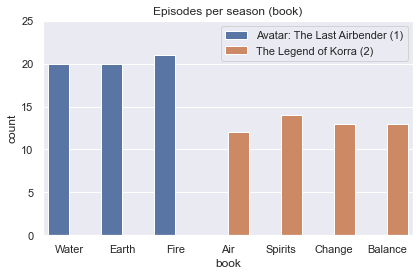

In [44]:
sns.countplot(x='book', hue='series', data=episode_info_df)
plt.yticks([i * 5 for i in range(6)])

plt.legend(labels=['Avatar: The Last Airbender (1)', 'The Legend of Korra (2)'])
plt.title('Episodes per season (book)')
plt.tight_layout()
plt.show()

The above plot shows that the first series contains one fewer season, but has on average more episodes per season than the second series. 
Additionally, the number of *total* episodes per series is also shown below:

In [48]:
episode_info_df.groupby('series').count().drop(columns=['Unnamed: 0', 'name', 'book_number', 'episode_number'])

,book
series,
1,61
2,52


*Avatar: The Last Airbender* has $61$ episodes, while *The Legend of Korra* has $52$ episodes. This makes the first series slightly longer in terms of running time, since each episode has a running time of approx. 20 minutes. We investigate these numbers to ensure a fair comparison of the two series later on.

### Number of words spoken per book
We saw that the two series are close to equal in episode count, but how does the dialogue differ in terms of length?

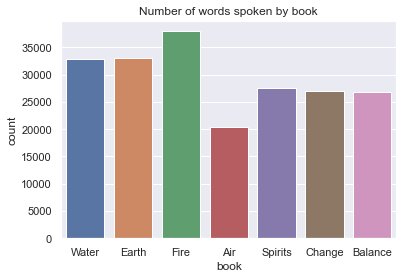

In [114]:
dialogue = transcript_df[['book', 'dialogue']]

num_tokens = []
for book_name in transcript_df['book'].unique():
    book_dialogue = transcript_df[transcript_df['book'].str.contains(book_name[0])]
    book_text = ' '.join(book_dialogue['dialogue'])
    
    # Extract tokens (also removes punctuation)
    tokenizer = nltk.RegexpTokenizer(r'[\w\']+')
    tokens = tokenizer.tokenize(book_text)
    
    # Convert to lower case
    tokens = [token.lower() for token in tokens]
    num_tokens.append(len(tokens))

sns.barplot(y=num_tokens, x=list(transcript_df['book'].unique()))

plt.title('Number of words spoken by book')
plt.ylabel('count')
plt.xlabel('book')
plt.show()



We find that the above results are consistent with the episode counts found previously. It makes sense that a higher episode count results in a higher amount of dialogue.
Argueably, the above is a trivial observation. Let us normalize the token count by the number of episodes to get a more telling result.

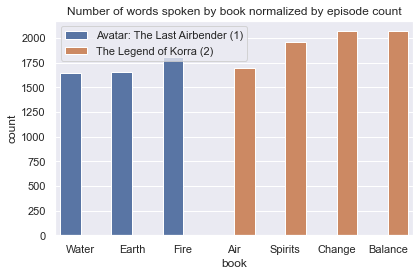

In [115]:
num_tokens_normalized = []
for book_name, token_count in zip(transcript_df['book'].unique(), num_tokens):
    episode_count = len(episode_info_df[episode_info_df.book == book_name])
    token_count_normalized = token_count / episode_count
    num_tokens_normalized.append(token_count_normalized)

tk_norm_df = pd.DataFrame({'tokens_norm': num_tokens_normalized, 'series': [1, 1, 1, 2, 2, 2, 2], 'book': transcript_df['book'].unique()})

sns.barplot(y='tokens_norm', hue='series', x='book', data=tk_norm_df)
legend = plt.legend()
legend.get_texts()[0].set_text('Avatar: The Last Airbender (1)')
legend.get_texts()[1].set_text('The Legend of Korra (2)')
plt.title('Number of words spoken by book normalized by episode count')
plt.ylabel('count')
plt.xlabel('book')

plt.tight_layout()
plt.show()

The above plot is more telling. Clearly, *The Legend of Korra* contains more dialogue on average per episode when compared to *Avatar: The Last Airbender*. Each episode of *The Legend of Korra* appears to be more densely packed. It will be interesting to see the implications of this in the subsequent analysis. 

### Word frequency by season

Here we will determine the most common words in each book. There's a good chance that this will mostly include stop words, but it will be interesting to compare each book nonetheless.

In [121]:
from functools import reduce

dialogue = transcript_df[['book', 'dialogue']]

word_freqs = []
for book_name in transcript_df['book'].unique():
    book_dialogue = transcript_df[transcript_df['book'].str.contains(book_name[0])]
    book_text = ' '.join(book_dialogue['dialogue'])
    
    # Extract tokens (also removes punctuation)
    tokenizer = nltk.RegexpTokenizer(r'[\w\']+')
    tokens = tokenizer.tokenize(book_text)
    
    # Convert to lower case
    tokens = [token.lower() for token in tokens]
    
    word_freqs.append(nltk.FreqDist(tokens))
    
dfs = []
for word_freq, book_name in zip(word_freqs, transcript_df['book'].unique()):
    dist = word_freq.most_common(10)
    
    # Adding a suffix for each word count
    df = pd.DataFrame({'word': [word for (word, _) in dist], 'count_' + book_name: [str(count) for (_, count) in dist]})
    dfs.append(df)


# 7-way outer merge
reduce(lambda left, right: pd.merge(left, right, on='word', how='outer'), dfs)

,word,count_Water,count_Earth,count_Fire,count_Air,count_Spirits,count_Change,count_Balance
0,the,1225,1285,1367,823,1166,928,931
1,you,1197,1171,1388,653,1001,908,975
2,to,920,979,1009,558,819,836,882
3,i,916,864,1342,539,825,803,907
4,a,620,600,673,370,416,489,419
5,and,414,487,640,323,429,468,494
6,it,398,423,505,NaN,261,NaN,249
7,of,388,472,439,271,363,369,353
8,is,358,405,382,239,322,267,NaN
9,that,340,NaN,NaN,NaN,NaN,NaN,251


The above table shows the top 10 most common words for each book. Note that the table actually has 13 rows, since not all books has the same words in their top 10. `NaN` values indicate words that are not part of that book's top 10. The number of rows is actually interesting, since it is close to 10. This means that each book generally has the same words in common. As expected, the distribution almost exclusively contains stop words, since these were not filtered up.

### Most connected characters (total degree)
We'll now be taking a look at some descriptive statistics of the network. Firstly, we would like to examine the most connected characters, and see if they are what we expect.

In [44]:
degree_list = sorted(GCC.degree(), reverse=True, key=lambda pair: pair[1])
for idx, (name, links) in enumerate(degree_list[:10]):
    print(str(idx + 1) + '.', name, 'with', links, 'links')


1. Aang with 349 links
2. Katara with 287 links
3. Sokka with 284 links
4. Zuko with 240 links
5. Toph Beifong with 208 links
6. Korra with 202 links
7. Tenzin with 155 links
8. Bolin with 147 links
9. Mako with 140 links
10. Iroh with 137 links


There are close to no surprises here in terms of total degree. The top 5 includes the most well known characters of the series, the core part of the original *Team Avatar*, *Aang*, *Katara*, *Sokka*, *Zuko* and *Toph*. Interestingly, Aang, the main character of the first series is not so far ahead in terms of links of the supporting cast. 

*Korra*, the main character of the second series *The Legend of Korra*, lands at 6th place with $202$ links. It appears the she interacted with less characters overall. This perhaps give us a clue of the differences between the two series. The remaining characters are also mainly associated (expect *Iroh*) with the second series, reinforcing this point.

We also wish to explore the in-degrees and out-degree separately to see if this will shed further light on the situation.

In [28]:
out_deg = [G.out_degree(node_name) for node_name in G.nodes]
in_deg = [G.in_degree(node_name) for node_name in G.nodes]
in_out_deg = [x + y for x, y in zip(out_deg, in_deg)]

### Most connected characters (in-degree)

In [47]:
in_degree_list = sorted(GCC.in_degree(), reverse=True, key=lambda pair: pair[1])
for idx, (name, links) in enumerate(in_degree_list[:10]):
    print(str(idx + 1) + '.', name, 'with', links, 'in-links')

1. Aang with 266 in-links
2. Sokka with 205 in-links
3. Katara with 201 in-links
4. Zuko with 167 in-links
5. Korra with 139 in-links
6. Toph Beifong with 136 in-links
7. Iroh with 91 in-links
8. Tenzin with 91 in-links
9. Bolin with 89 in-links
10. Appa with 84 in-links


The in-degree tells the same story. Characters only move a place or two. It is interesting to see that *Appa* is the character with the 10th largest in-degree with $84$ links! 
Appa is a flying bison (i.e. non-human) that cannot talk. He is used as the primary means of transporation in the first series. It is amusing that a character which cannot even directly communicate with other characters has such a large in-degree.

### Most connected characters (out degree)

In [48]:
out_degree_list = sorted(GCC.out_degree(), reverse=True, key=lambda pair: pair[1])
for idx, (name, links) in enumerate(out_degree_list[:10]):
    print(str(idx + 1) + '.', name, 'with', links, 'out-links')

1. Katara with 86 out-links
2. Aang with 83 out-links
3. Sokka with 79 out-links
4. Zuko with 73 out-links
5. Toph Beifong with 72 out-links
6. Tenzin with 64 out-links
7. Korra with 63 out-links
8. Lin Beifong with 63 out-links
9. Jinora with 60 out-links
10. Bolin with 58 out-links


### Average shortest path length

In [31]:
nx.average_shortest_path_length(GCC)

2.483110578547946

### Clustering coefficient

In [32]:
nx.average_clustering(GCC)

0.5789145460468168

### Total degree distribution

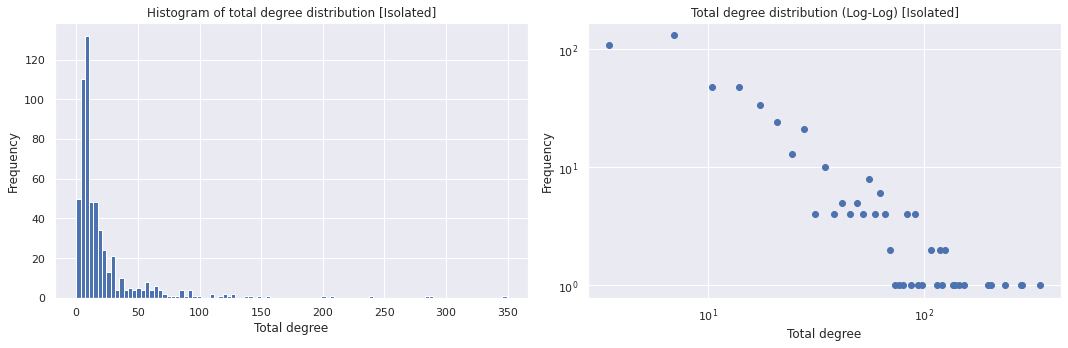

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

hist, bins = np.histogram(in_out_deg, bins=100)
axes[0].hist(bins[:-1], bins, weights=hist)
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Total degree')
axes[0].set_title('Histogram of total degree distribution [Isolated]')

axes[1].plot(bins[:-1], hist, 'bo')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylabel('Frequency')
axes[1].set_xlabel('Total degree')
axes[1].set_title('Total degree distribution (Log-Log) [Isolated]')

plt.tight_layout()
plt.show()

### Distribution of nationalities

In [35]:
nationalities = [attribs['nationality'] for _, attribs in G.nodes(data=True)]

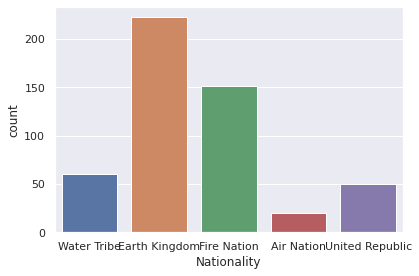

In [37]:
sns.countplot(x=nationalities)
plt.xlabel('Nationality')
plt.tight_layout()
plt.show()

### Distribution of gender

In [38]:
genders = [attribs['gender'] for _, attribs in G.nodes(data=True)]

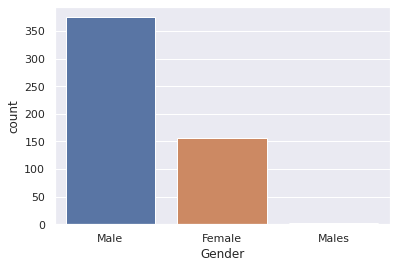

In [39]:
sns.countplot(x=genders)
plt.xlabel('Gender')
plt.show()

### Distribution of bending styles

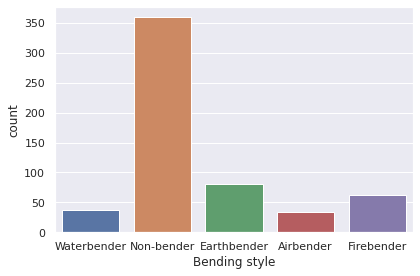

In [40]:
benders = [attribs['bending_art'] for _, attribs in G.nodes(data=True)]

sns.countplot(x=benders)
plt.xlabel('Bending style')
plt.tight_layout()
plt.show()

## Visualizing the network

We'll be using `ForceAtlas2` for finding node positions.

In [25]:
GCC_undirected = GCC.to_undirected()

Finding color of nodes based on nationality.

In [28]:
color_map = []
for node, attribs in GCC_undirected.nodes(data=True):
    if attribs['nationality'] == 'Earth Kingdom':
        color_map.append('#987654')
    elif attribs['nationality'] == 'Fire Nation':
        color_map.append('Red')
    elif attribs['nationality'] == 'Water Tribe':
        color_map.append('#00a0ff')
    elif attribs['nationality'] == 'Air Nation':
        color_map.append('#bbc6cb')

Finding node sizes based on total degree.

In [29]:
degree_dict = dict(GCC_undirected.degree)
node_sizes = [n * 10 for n in degree_dict.values()]

In [31]:
fa2_object =  ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=2,

                        # Log
                        verbose=False)


positions = fa2_object.forceatlas2_networkx_layout(GCC_undirected, pos=None, iterations=2000)

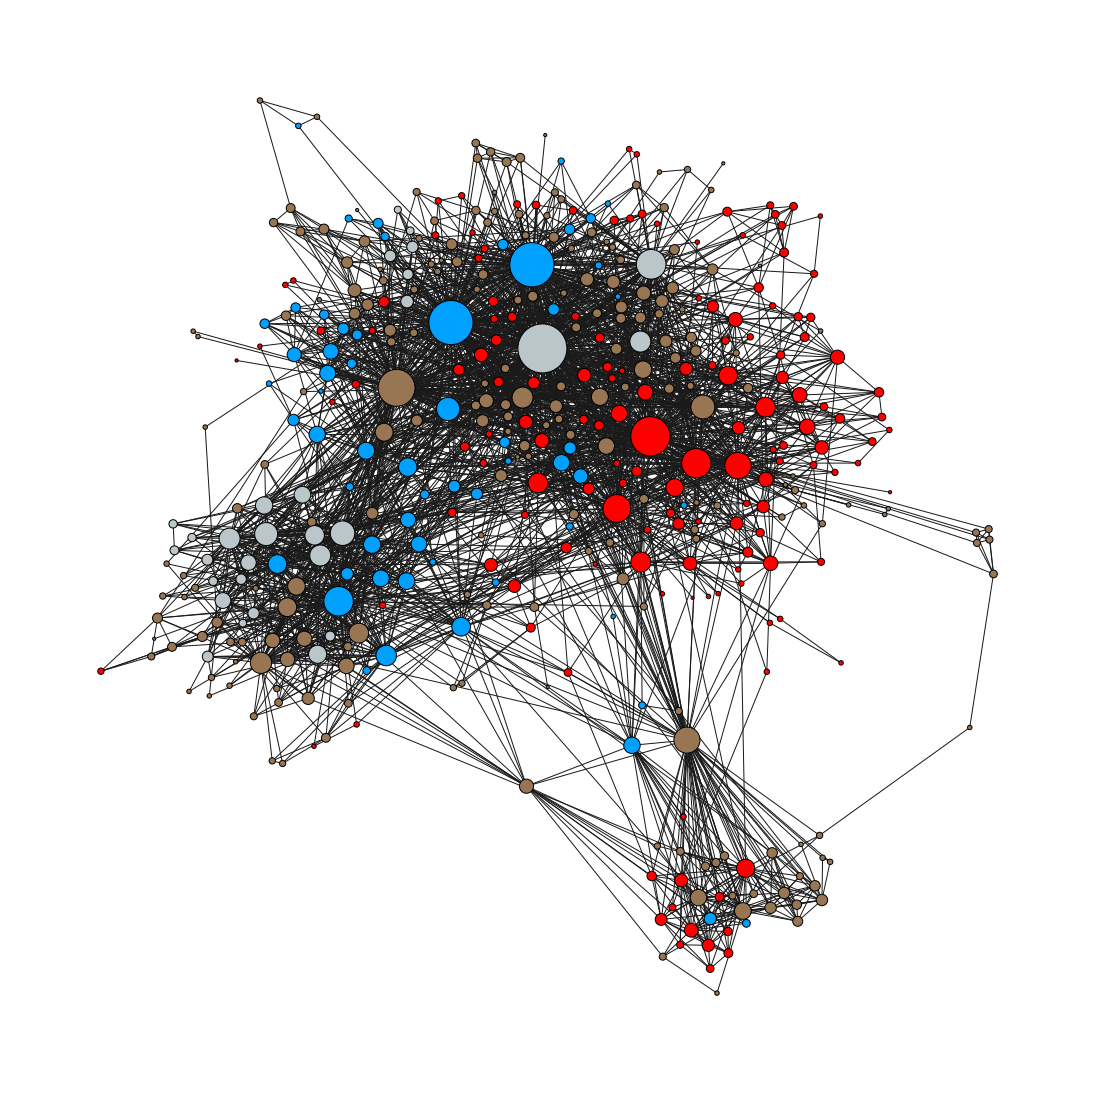

In [33]:
plt.figure(3, figsize=(15,15))
nx.draw(GCC_undirected, positions, node_color=color_map, node_size=node_sizes, edgecolors='black')
plt.show()

## Tools, theory and analysis